Drive: https://drive.google.com/drive/folders/1nqlc7Zz92M5mj2NKjwUTwC8hOt9GLlIn?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
USERNAME = 'peketivenkata.v'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20, depth=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        input_dim = 784
        first_hidden = 512
        
        # Build encoder hidden dims
        hidden_dims = [first_hidden]
        curr = first_hidden
        for _ in range(depth - 1):
            curr = max(curr // 2, latent_dim)
            hidden_dims.append(curr)
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.ReLU())
            prev_dim = h
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        decoder_hidden = list(reversed(hidden_dims))
        decoder_layers = []
        prev_dim = latent_dim
        for h in decoder_hidden:
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(nn.ReLU())
            prev_dim = h
        
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss with beta-weighting on KL divergence"""
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

def train_epoch(model, train_loader, optimizer, beta=1.0):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    total_bce = 0
    total_kld = 0
    
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()
    
    n = len(train_loader.dataset)
    return train_loss / n, total_bce / n, total_kld / n

In [5]:
def calculate_fid_simple(real_images, generated_images):
    """Calculate simplified FID using pixel statistics"""
    # Convert to numpy and flatten
    if torch.is_tensor(real_images):
        real_images = real_images.cpu().numpy()
    if torch.is_tensor(generated_images):
        generated_images = generated_images.cpu().numpy()
    
    real_flat = real_images.reshape(real_images.shape[0], -1)
    gen_flat = generated_images.reshape(generated_images.shape[0], -1)
    
    # Calculate statistics
    mu1 = np.mean(real_flat, axis=0)
    mu2 = np.mean(gen_flat, axis=0)
    sigma1 = np.cov(real_flat, rowvar=False)
    sigma2 = np.cov(gen_flat, rowvar=False)
    
    # Add small epsilon for numerical stability
    sigma1 += np.eye(sigma1.shape[0]) * 1e-6
    sigma2 += np.eye(sigma2.shape[0]) * 1e-6
    
    # Calculate FID
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [6]:
# ============================================================================
# Latent Space Extraction
# ============================================================================
def extract_latent_representations(model, data_loader, selected_classes=None):
    """Extract latent representations and labels"""
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())
    
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Filter by selected classes if specified
    if selected_classes is not None:
        mask = np.isin(labels, selected_classes)
        latents = latents[mask]
        labels = labels[mask]
    
    return latents, labels

# ============================================================================
# Latent Space Visualization
# ============================================================================
def visualize_latent_space(latents, labels, title, filename, use_tsne=True):
    """Visualize latent space with t-SNE if needed"""
    latent_dim = latents.shape[1]
    
    # Use t-SNE for high-dimensional spaces
    if latent_dim > 2 and use_tsne:
        print(f"Applying t-SNE to reduce from {latent_dim}D to 2D...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        latents_2d = tsne.fit_transform(latents)
    else:
        latents_2d = latents[:, :2]  # Use first 2 dimensions
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                        c=labels, cmap='tab10', alpha=0.6, s=10)
    ax.set_xlabel('Dimension 1' if not use_tsne or latent_dim <= 2 else 't-SNE Component 1')
    ax.set_ylabel('Dimension 2' if not use_tsne or latent_dim <= 2 else 't-SNE Component 2')
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax, label='Class')
    ax.grid(True, alpha=0.3)
    
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
             transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.close()

# ============================================================================
# Latent Space Visualization for Selected Classes
# ============================================================================
def visualize_latent_space_beta(model, data_loader, selected_classes, beta, epoch):
    """Visualize latent space for selected classes"""
    latents, labels = extract_latent_representations(model, data_loader, selected_classes)
    
    # Use t-SNE if needed
    if model.latent_dim > 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        latents_2d = tsne.fit_transform(latents)
    else:
        latents_2d = latents
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for cls in selected_classes:
        mask = labels == cls
        ax.scatter(latents_2d[mask, 0], latents_2d[mask, 1],
                  c=[colors[cls]], alpha=0.6, s=20, label=class_names[cls])
    
    ax.set_title(f'Latent Space - β={beta}, Final Epoch {epoch}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
             transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    return fig

Loading Fashion-MNIST dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.6MB/s]


Training samples: 60000
Test samples: 10000

SECTION 4.3: Model Architecture Experiments

Training: Small (2D, depth=2)
Total parameters: 1,068,820
Epoch  5 | Loss: 260.8229 | BCE: 254.5081 | KLD: 6.3149
Epoch 10 | Loss: 257.5201 | BCE: 251.0527 | KLD: 6.4674
Epoch 15 | Loss: 255.7398 | BCE: 249.1856 | KLD: 6.5543
Saved: latent_space_Small_(2D,_depth=2)_peketivenkata.v.png

Training: Medium (10D, depth=2)
Total parameters: 1,074,980
Epoch  5 | Loss: 244.0764 | BCE: 232.8910 | KLD: 11.1855
Epoch 10 | Loss: 240.3402 | BCE: 228.5459 | KLD: 11.7944
Epoch 15 | Loss: 238.8019 | BCE: 226.8206 | KLD: 11.9813
Applying t-SNE to reduce from 10D to 2D...
Saved: latent_space_Medium_(10D,_depth=2)_peketivenkata.v.png

Training: Large (20D, depth=3)
Total parameters: 1,140,792
Epoch  5 | Loss: 247.0374 | BCE: 237.7956 | KLD: 9.2418
Epoch 10 | Loss: 243.8561 | BCE: 234.3387 | KLD: 9.5174
Epoch 15 | Loss: 242.4582 | BCE: 232.8069 | KLD: 9.6512
Applying t-SNE to reduce from 20D to 2D...
Saved: latent_sp

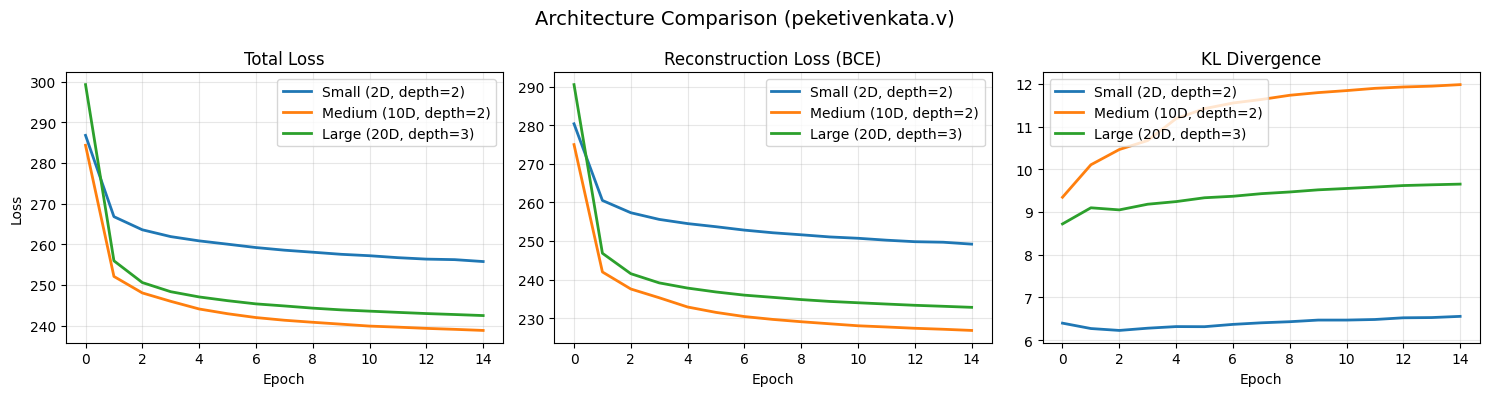

In [7]:
# ============================================================================
# Data Loading
# ============================================================================
print("Loading Fashion-MNIST dataset...")
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# # ============================================================================
# # Section 4.3: Model Architecture Experiments
# # ============================================================================
print("\n" + "="*80)
print("SECTION 4.3: Model Architecture Experiments")
print("="*80)

architectures = [
    {'latent_dim': 2, 'depth': 2, 'name': 'Small (2D, depth=2)'},
    {'latent_dim': 10, 'depth': 2, 'name': 'Medium (10D, depth=2)'},
    {'latent_dim': 20, 'depth': 3, 'name': 'Large (20D, depth=3)'},
]

arch_results = {}

for arch in architectures:
    print(f"\n{'='*60}")
    print(f"Training: {arch['name']}")
    print(f"{'='*60}")
    
    model = VAE(latent_dim=arch['latent_dim'], depth=arch['depth']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {n_params:,}")
    
    losses = {'total': [], 'bce': [], 'kld': []}
    n_epochs = 15
    
    for epoch in range(1, n_epochs + 1):
        avg_loss, avg_bce, avg_kld = train_epoch(model, train_loader, optimizer, beta=1.0)
        losses['total'].append(avg_loss)
        losses['bce'].append(avg_bce)
        losses['kld'].append(avg_kld)
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch:2d} | Loss: {avg_loss:.4f} | BCE: {avg_bce:.4f} | KLD: {avg_kld:.4f}")
    
    arch_results[arch['name']] = {
        'model': model,
        'losses': losses,
        'n_params': n_params,
        'config': arch
    }
    
    # Visualize latent space
    latents, labels = extract_latent_representations(model, test_loader)
    use_tsne = arch['latent_dim'] > 2
    visualize_latent_space(latents, labels, 
                          f"Latent Space - {arch['name']}",
                          f"latent_space_{arch['name'].replace(' ', '_')}_{USERNAME}.png",
                          use_tsne=use_tsne)

# Architecture comparison plot
print("\nGenerating architecture comparison...")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f'Architecture Comparison ({USERNAME})', fontsize=14)

for name, result in arch_results.items():
    axes[0].plot(result['losses']['total'], label=name, linewidth=2)
    axes[1].plot(result['losses']['bce'], label=name, linewidth=2)
    axes[2].plot(result['losses']['kld'], label=name, linewidth=2)

axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Reconstruction Loss (BCE)')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_title('KL Divergence')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'architecture_comparison_{USERNAME}.png', dpi=150, bbox_inches='tight')
print(f"Saved: architecture_comparison_{USERNAME}.png")
plt.show()




SECTION 4.6: Beta-VAE Experiments

Training with β = 0.1
Epoch 5, Loss: 224.7251, BCE: 220.7720, KLD: 39.5306
Epoch 10, Loss: 219.1131, BCE: 215.1937, KLD: 39.1940
Epoch 15, Loss: 217.1967, BCE: 213.2770, KLD: 39.1967
Saved: latent_space_beta_0.1_peketivenkata.v.png


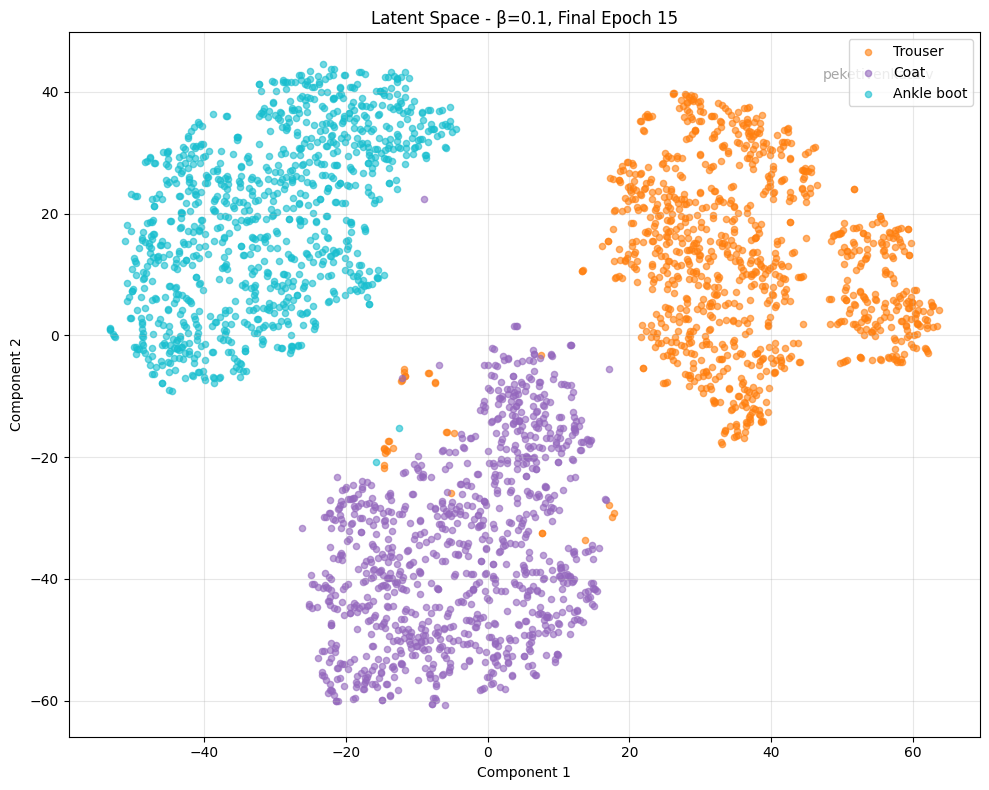

Saved: loss_curves_beta_0.1_peketivenkata.v.png


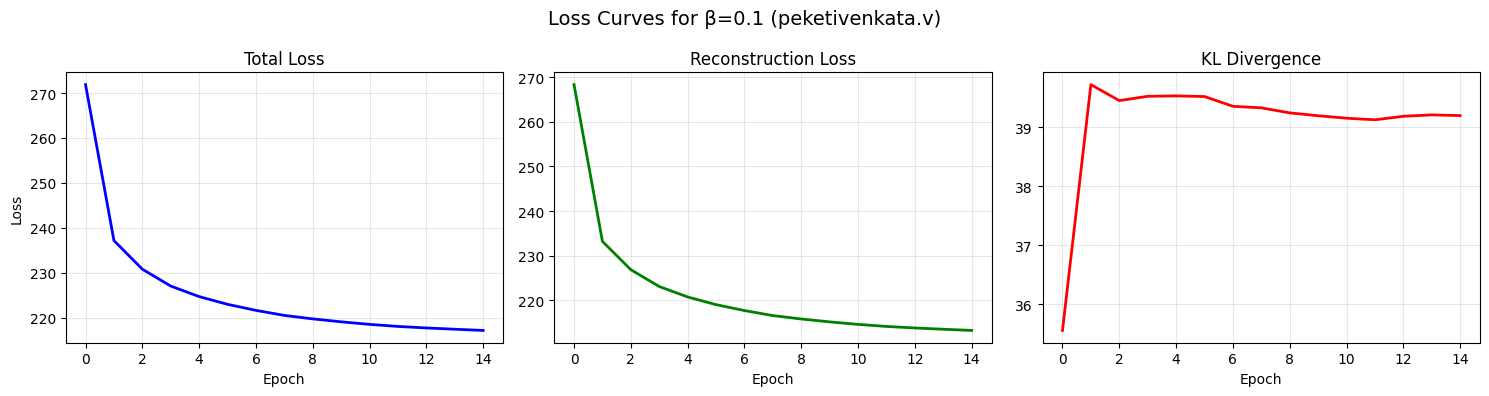


Training with β = 0.5
Epoch 5, Loss: 235.5609, BCE: 227.5565, KLD: 16.0089
Epoch 10, Loss: 231.3998, BCE: 223.0377, KLD: 16.7241
Epoch 15, Loss: 229.7893, BCE: 221.2375, KLD: 17.1037
Saved: latent_space_beta_0.5_peketivenkata.v.png


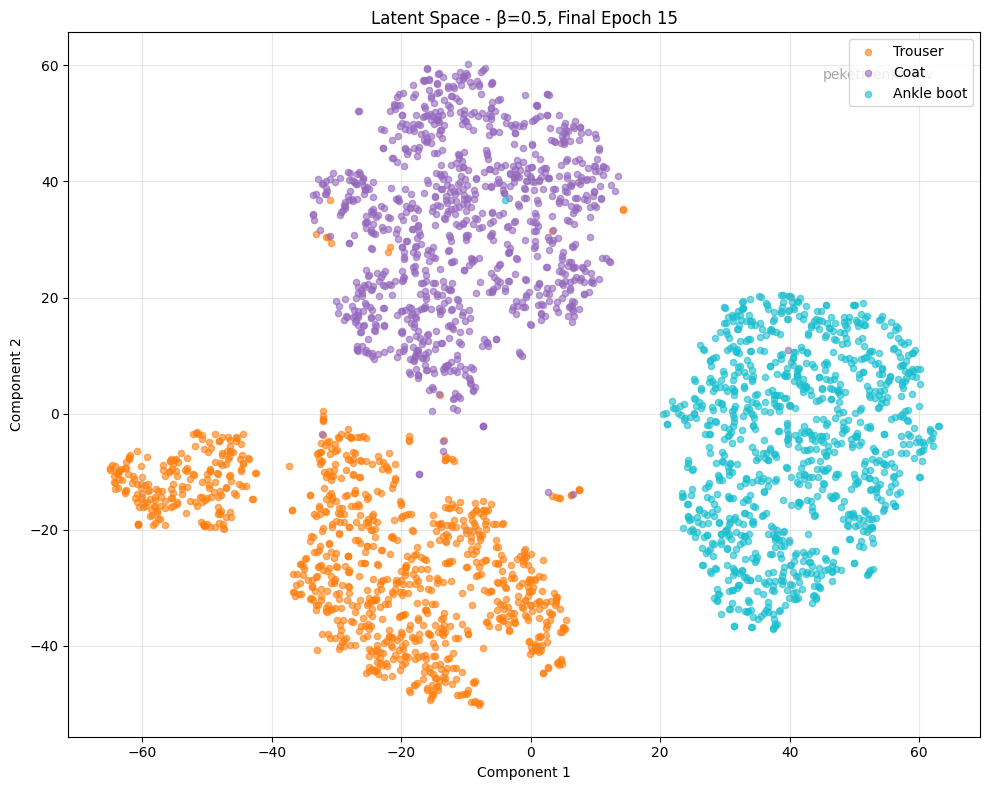

Saved: loss_curves_beta_0.5_peketivenkata.v.png


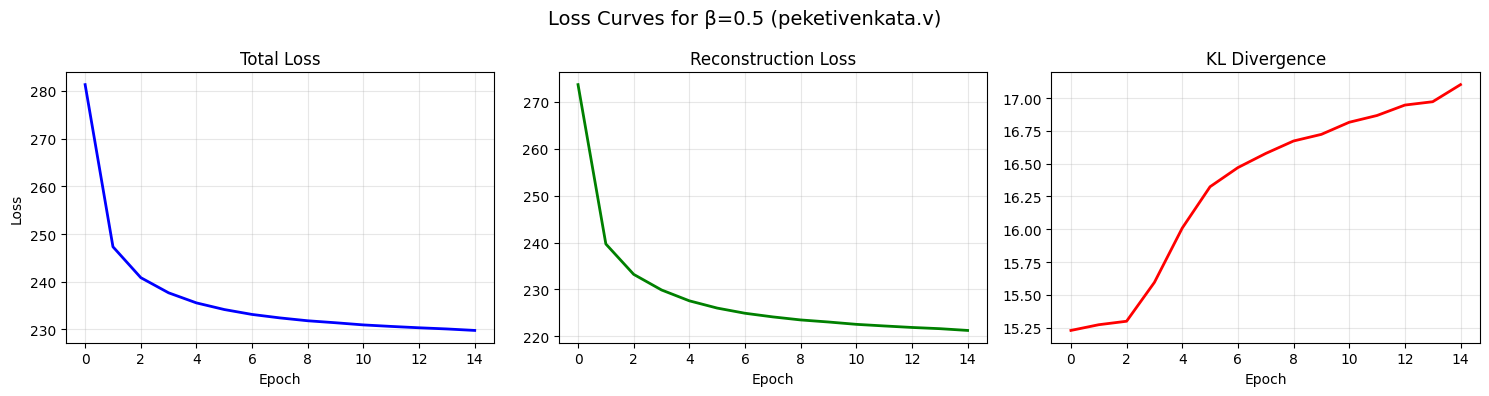


Training with β = 1.0
Epoch 5, Loss: 243.7911, BCE: 231.5809, KLD: 12.2101
Epoch 10, Loss: 240.0136, BCE: 227.2683, KLD: 12.7453
Epoch 15, Loss: 238.4318, BCE: 225.5270, KLD: 12.9048
Saved: latent_space_beta_1.0_peketivenkata.v.png


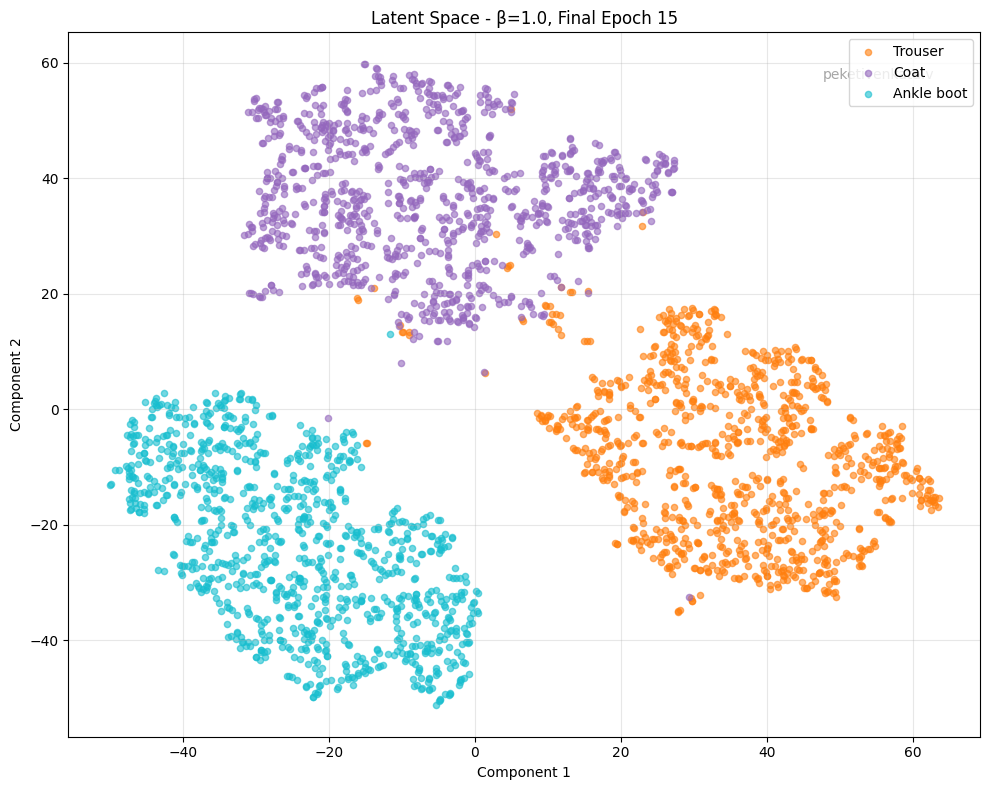

Saved: loss_curves_beta_1.0_peketivenkata.v.png


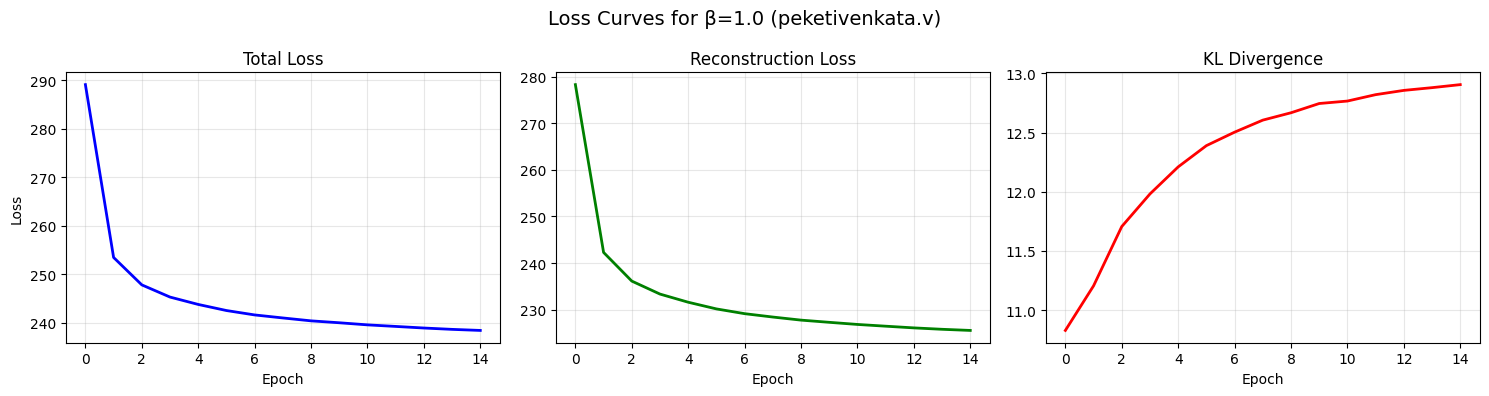


Beta-VAE Summary
Beta       Final BCE       Final KLD       Total Loss     
0.1        213.2770        39.1967         217.1967       
0.5        221.2375        17.1037         229.7893       
1.0        225.5270        12.9048         238.4318       

SECTION 4.7: Evaluation and Visualization

Generating reconstructions...
Saved: reconstruction_peketivenkata.v.png


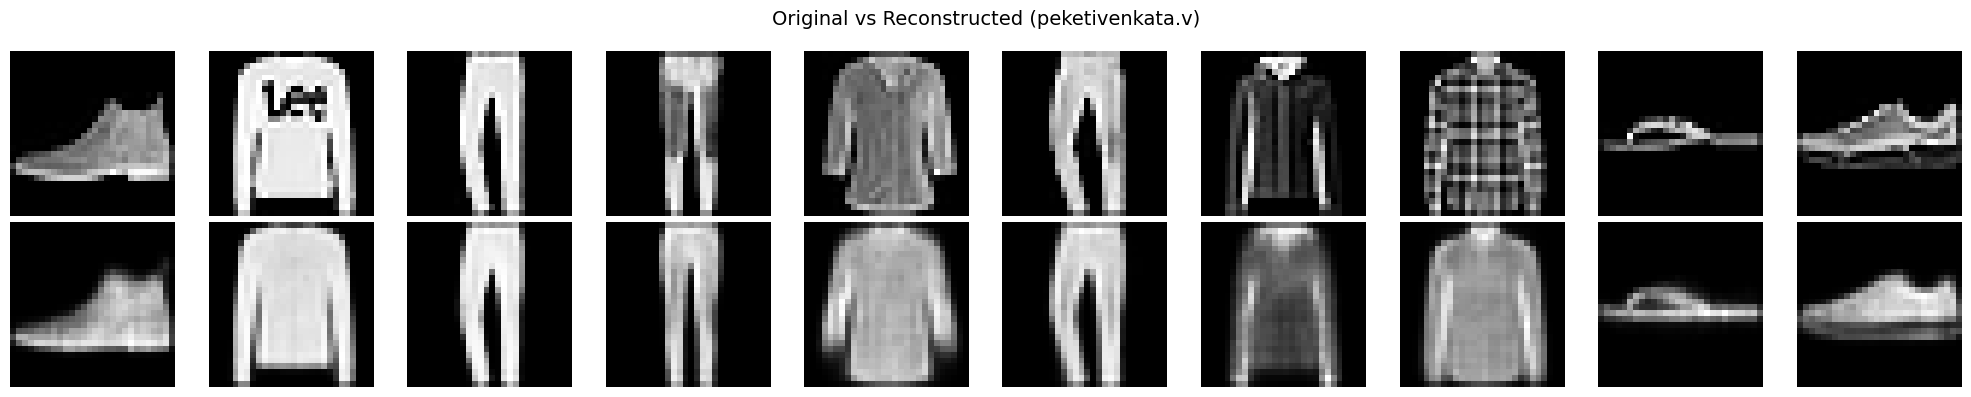


Generating new samples...


/tmp/ipykernel_48/325001436.py:130: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


Saved: generated_samples_peketivenkata.v.png


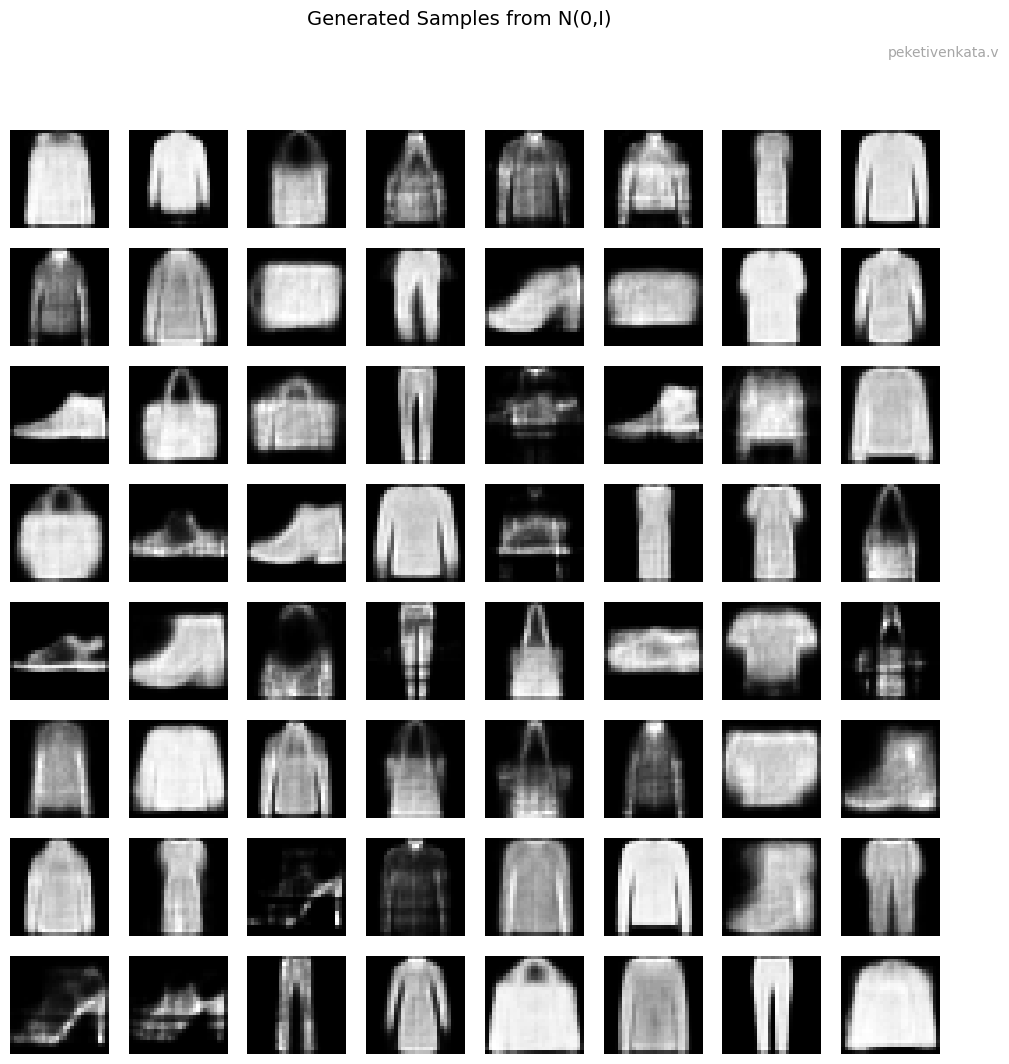


Calculating FID score...
Computing FID on 10000 images...
FID Score (full test set): 8.2259

SECTION 4.8: Effect of Frozen Latent Parameters

Generating samples with frozen μ=0, σ=0.1


/tmp/ipykernel_48/325001436.py:191: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


Saved: frozen_samples_sigma_0.1_peketivenkata.v.png


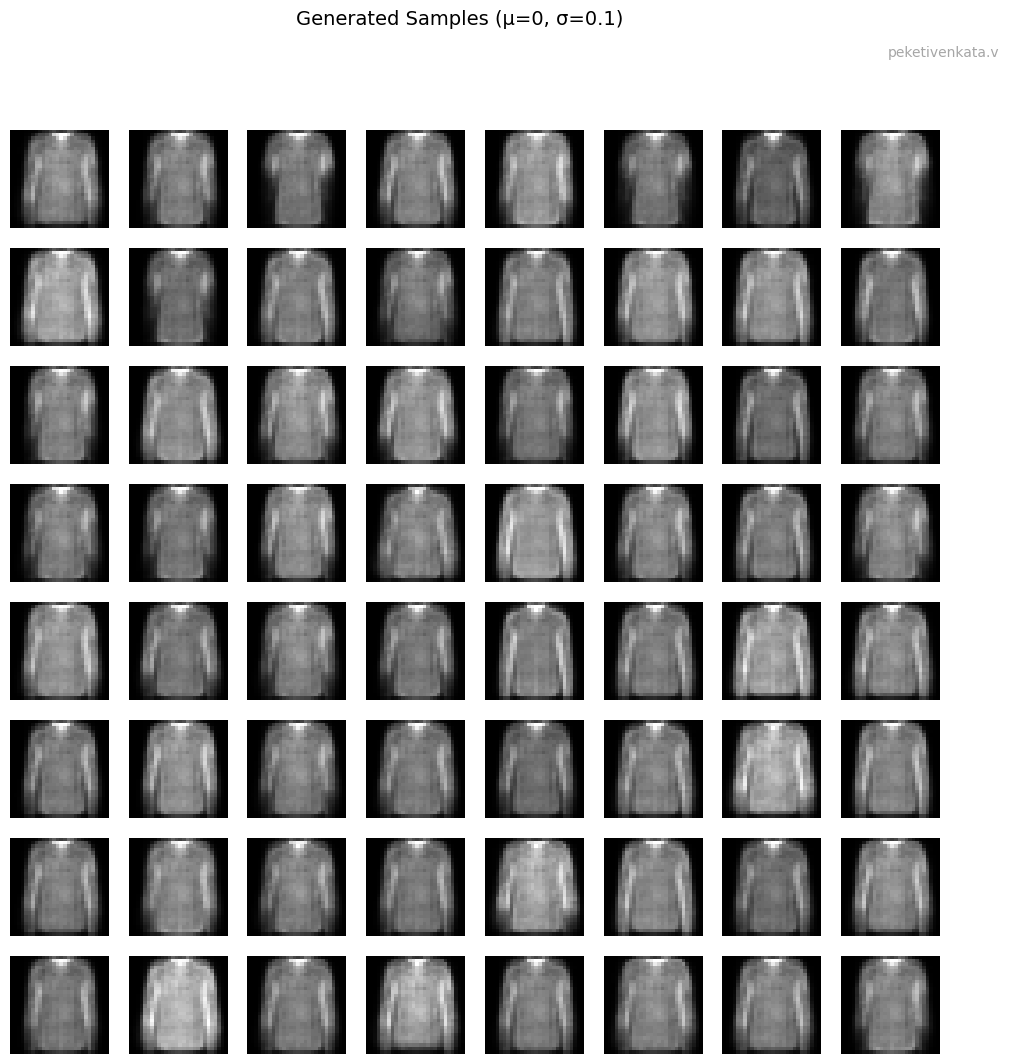


Generating samples with frozen μ=0, σ=0.5
Saved: frozen_samples_sigma_0.5_peketivenkata.v.png


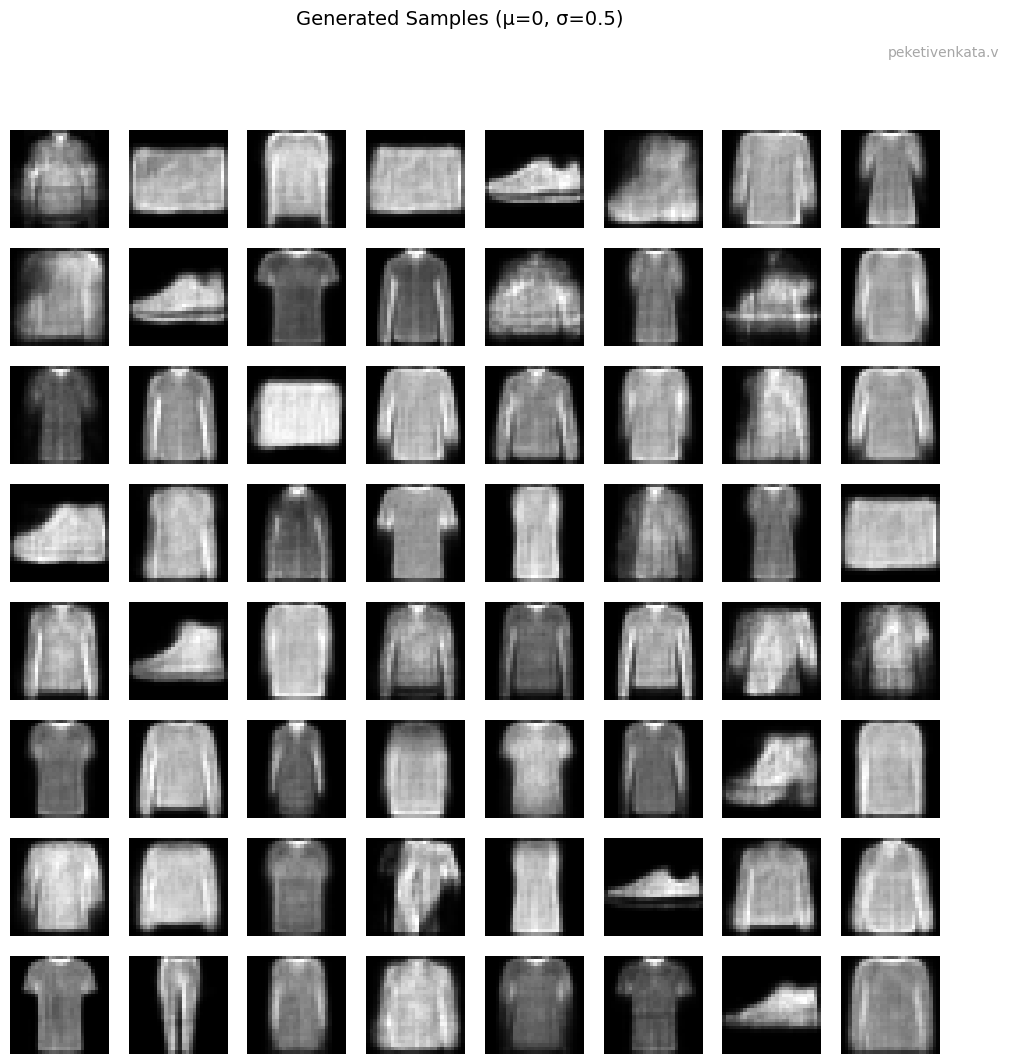


Generating samples with frozen μ=0, σ=1.0
Saved: frozen_samples_sigma_1.0_peketivenkata.v.png


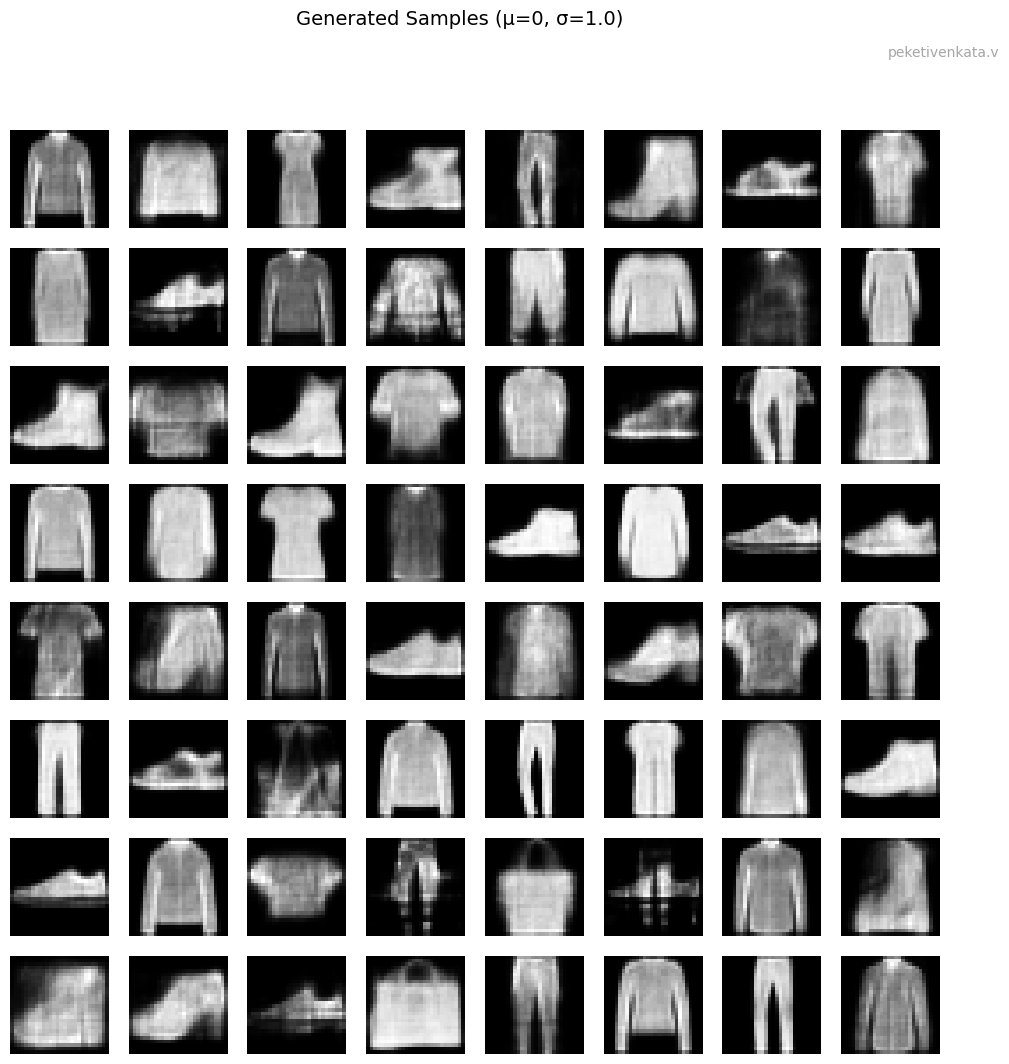


Frozen Parameters Analysis
Sigma      Sample Std      Sample Diversity    
0.1        0.1232          1.4916              
0.5        0.1857          5.1747              
1.0        0.2829          7.6276              

FINAL SUMMARY REPORT

1. Architecture Experiments:
------------------------------------------------------------
Small (2D, depth=2):
  - Parameters: 1,068,820
  - Final Loss: 255.7398
  - Final BCE: 249.1856
  - Final KLD: 6.5543
Medium (10D, depth=2):
  - Parameters: 1,074,980
  - Final Loss: 238.8019
  - Final BCE: 226.8206
  - Final KLD: 11.9813
Large (20D, depth=3):
  - Parameters: 1,140,792
  - Final Loss: 242.4582
  - Final BCE: 232.8069
  - Final KLD: 9.6512

2. Beta-VAE Results:
------------------------------------------------------------
β = 0.1:
  - Final Loss: 217.1967
  - Final BCE: 213.2770
  - Final KLD: 39.1967
β = 0.5:
  - Final Loss: 229.7893
  - Final BCE: 221.2375
  - Final KLD: 17.1037
β = 1.0:
  - Final Loss: 238.4318
  - Final BCE: 225.5270
  - Fi

In [8]:
# ============================================================================
# Section 4.6: Beta-VAE Experiments with Latent Space Evolution
# ============================================================================
print("\n" + "="*80)
print("SECTION 4.6: Beta-VAE Experiments")
print("="*80)

beta_values = [0.1, 0.5, 1.0]
latent_dim = 20  # Use 2D for easy visualization
n_epochs = 15
selected_classes = [1, 4, 9]  # T-shirt, Pullover, Coat

beta_results = {}

for beta in beta_values:
    print(f"\n{'='*60}")
    print(f"Training with β = {beta}")
    print(f"{'='*60}")
    
    model = VAE(latent_dim=latent_dim, depth=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    losses = {'total': [], 'bce': [], 'kld': []}
    
    for epoch in range(1, n_epochs + 1):
        avg_loss, avg_bce, avg_kld = train_epoch(model, train_loader, optimizer, beta)
        losses['total'].append(avg_loss)
        losses['bce'].append(avg_bce)
        losses['kld'].append(avg_kld)
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')
    
    beta_results[beta] = {
        'model': model,
        'losses': losses
    }
    
    # Visualize final latent space for selected classes
    fig = visualize_latent_space_beta(model, test_loader, selected_classes, beta, n_epochs)
    plt.savefig(f'latent_space_beta_{beta}_{USERNAME}.png', dpi=150, bbox_inches='tight')
    print(f"Saved: latent_space_beta_{beta}_{USERNAME}.png")
    plt.show()
    
    # Loss curves
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'Loss Curves for β={beta} ({USERNAME})', fontsize=14)
    
    axes[0].plot(losses['total'], 'b-', linewidth=2)
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(losses['bce'], 'g-', linewidth=2)
    axes[1].set_title('Reconstruction Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(losses['kld'], 'r-', linewidth=2)
    axes[2].set_title('KL Divergence')
    axes[2].set_xlabel('Epoch')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'loss_curves_beta_{beta}_{USERNAME}.png', dpi=150, bbox_inches='tight')
    print(f"Saved: loss_curves_beta_{beta}_{USERNAME}.png")
    plt.show()

# Beta comparison summary
print("\n" + "="*60)
print("Beta-VAE Summary")
print("="*60)
print(f"{'Beta':<10} {'Final BCE':<15} {'Final KLD':<15} {'Total Loss':<15}")
for beta in beta_values:
    losses = beta_results[beta]['losses']
    print(f"{beta:<10} {losses['bce'][-1]:<15.4f} {losses['kld'][-1]:<15.4f} {losses['total'][-1]:<15.4f}")

# ============================================================================
# Section 4.7: Evaluation and Visualization
# ============================================================================
print("\n" + "="*80)
print("SECTION 4.7: Evaluation and Visualization")
print("="*80)

# Use the β=1.0 model for evaluation
model = beta_results[1.0]['model']
model.eval()

# 1. Reconstruction visualization
print("\nGenerating reconstructions...")
with torch.no_grad():
    test_data = next(iter(test_loader))[0][:10].to(device)
    recon, _, _ = model(test_data)
    
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    fig.suptitle(f'Original vs Reconstructed ({USERNAME})', fontsize=14)
    
    for i in range(10):
        axes[0, i].imshow(test_data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', fontsize=12)
        
        axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Reconstructed', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'reconstruction_{USERNAME}.png', dpi=150, bbox_inches='tight')
    print(f"Saved: reconstruction_{USERNAME}.png")
    plt.show()

# 2. Generate new samples
print("\nGenerating new samples...")
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z).cpu()
    
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(samples[i*8+j].view(28, 28), cmap='gray')
            axes[i, j].axis('off')
    
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    plt.suptitle('Generated Samples from N(0,I)', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'generated_samples_{USERNAME}.png', dpi=150, bbox_inches='tight')
    print(f"Saved: generated_samples_{USERNAME}.png")
    plt.show()

# 3. Calculate FID score
print("\nCalculating FID score...")
with torch.no_grad():
    # Get all real test images
    all_real_images = []
    for data, _ in test_loader:
        all_real_images.append(data)
    real_images = torch.cat(all_real_images, dim=0)  # Full test set
    
    # Generate same number of fake images
    n_samples = real_images.shape[0]
    gen_images_list = []
    batch_size = 128
    
    for i in range(0, n_samples, batch_size):
        batch_samples = min(batch_size, n_samples - i)
        z = torch.randn(batch_samples, latent_dim).to(device)
        gen_batch = model.decode(z).view(-1, 1, 28, 28).cpu()
        gen_images_list.append(gen_batch)
    
    gen_images = torch.cat(gen_images_list, dim=0)

print(f"Computing FID on {n_samples} images...")
fid_score = calculate_fid_simple(real_images, gen_images)
print(f"FID Score (full test set): {fid_score:.4f}")

# ============================================================================
# Section 4.8: Frozen Latent Parameters
# ============================================================================
print("\n" + "="*80)
print("SECTION 4.8: Effect of Frozen Latent Parameters")
print("="*80)

sigma_values = [0.1, 0.5, 1.0]
frozen_results = {}

for sigma in sigma_values:
    print(f"\nGenerating samples with frozen μ=0, σ={sigma}")
    
    with torch.no_grad():
        # Generate with frozen parameters
        z = torch.randn(64, latent_dim).to(device) * sigma
        samples = model.decode(z).cpu()
        
        frozen_results[sigma] = samples
        
        # Visualize
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(8):
            for j in range(8):
                axes[i, j].imshow(samples[i*8+j].view(28, 28), cmap='gray')
                axes[i, j].axis('off')
        
        plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
                 transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.suptitle(f'Generated Samples (μ=0, σ={sigma})', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'frozen_samples_sigma_{sigma}_{USERNAME}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: frozen_samples_sigma_{sigma}_{USERNAME}.png")
        plt.show()

# Calculate sample variance for each sigma
print("\n" + "="*60)
print("Frozen Parameters Analysis")
print("="*60)
print(f"{'Sigma':<10} {'Sample Std':<15} {'Sample Diversity':<20}")
for sigma in sigma_values:
    samples = frozen_results[sigma].numpy()
    sample_std = np.std(samples)
    # Diversity: average pairwise difference
    flat_samples = samples.reshape(64, -1)
    pairwise_diff = np.mean([np.linalg.norm(flat_samples[i] - flat_samples[j]) 
                             for i in range(10) for j in range(i+1, 10)])
    print(f"{sigma:<10} {sample_std:<15.4f} {pairwise_diff:<20.4f}")

# ============================================================================
# Final Summary Report
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n1. Architecture Experiments:")
print("-" * 60)
for name, result in arch_results.items():
    print(f"{name}:")
    print(f"  - Parameters: {result['n_params']:,}")
    print(f"  - Final Loss: {result['losses']['total'][-1]:.4f}")
    print(f"  - Final BCE: {result['losses']['bce'][-1]:.4f}")
    print(f"  - Final KLD: {result['losses']['kld'][-1]:.4f}")

print("\n2. Beta-VAE Results:")
print("-" * 60)
for beta in beta_values:
    losses = beta_results[beta]['losses']
    print(f"β = {beta}:")
    print(f"  - Final Loss: {losses['total'][-1]:.4f}")
    print(f"  - Final BCE: {losses['bce'][-1]:.4f}")
    print(f"  - Final KLD: {losses['kld'][-1]:.4f}")

print(f"\n3. Generation Quality:")
print("-" * 60)
print(f"  - FID Score (full test set): {fid_score:.4f}")

print("\n" + "="*80)
print("All experiments completed successfully!")
print("="*80)